In [1]:
import os, glob
import numpy as np 

import astropy.io.fits as fits
from astropy.table import Table as aT
from astropy.table import vstack

In [2]:
import pfs.datamodel as datamodel
import lsst.daf.persistence as dafPersist

In [3]:
import matplotlib.pyplot as plt

compile cosmology targets

In [4]:
for i, f in enumerate(glob.glob('/shared/2d/rerun/edr2-20231203/targets/run*_co_*csv')): 
    targ = aT.read(f)
    if 'object_id' in targ.colnames: targ.rename_column('object_id', 'obj_id')
    if i == 0:  targs = targ
    else: targs = vstack([targs, targ])

In [5]:
targs

obj_id,ra,dec,g_cmodel_mag,g_cmodel_magerr,r_cmodel_mag,r_cmodel_magerr,i_cmodel_mag,i_cmodel_magerr,z_cmodel_mag,z_cmodel_magerr,y_cmodel_mag,y_cmodel_magerr,g_cmodel_flux,g_cmodel_fluxerr,r_cmodel_flux,r_cmodel_fluxerr,i_cmodel_flux,i_cmodel_fluxerr,z_cmodel_flux,z_cmodel_fluxerr,y_cmodel_flux,y_cmodel_fluxerr
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
43365704967145244,219.58806439496792,1.583100010834337,24.032,0.040393874,24.109118,0.04799594,23.885166,0.032003265,23.52327,0.053351797,23.356781,0.10316485,885.5236,32.94514,824.8079,36.461372,1013.7563,29.881578,1414.7893,69.52108,1649.2529,156.70927
42297142873710495,218.5550514401301,1.2859814714896636,24.006561,0.020474253,23.927114,0.036991566,23.588879,0.022403108,23.690155,0.06582771,23.40154,0.115666285,906.5153,17.094599,975.3361,33.230183,1331.8287,27.480988,1213.2157,73.55674,1582.6465,168.60342
42292031862631098,217.87579070240025,0.2437820471078315,24.371178,0.03318277,24.318323,0.046417374,24.04773,0.04081232,23.728903,0.073064424,23.404526,0.12189379,647.93097,19.802364,680.2534,29.082182,872.78613,32.80763,1170.6815,78.78081,1578.3014,177.19327
43365288355303809,220.157124947886,1.488463741531131,24.331495,0.032082427,24.106194,0.04142757,23.822643,0.028186295,23.321875,0.045915663,23.187548,0.06989933,672.0505,19.858425,827.0329,31.556435,1073.8467,27.877638,1703.1388,72.02555,1927.4395,124.0879
43360765754756197,218.8278508497116,1.9561370317484548,24.295273,0.06377363,24.154543,0.062186655,23.560455,0.037615664,23.294035,0.09508873,--,--,694.8497,40.81386,791.0114,45.305992,1367.1554,47.36552,1747.3748,153.035,--,--
42296180801033038,219.72838598988483,1.2646391113948718,24.601398,0.05992284,24.432835,0.091124035,24.54345,0.06788697,24.112965,0.10094889,24.410156,0.27763152,524.1318,28.927345,612.1611,51.377663,552.86633,34.568638,821.8915,76.417305,625.08234,159.83861
43365838111139079,219.48973618218875,1.5413428018218096,24.823114,0.07889078,24.565117,0.07386382,24.243855,0.05620135,23.669405,0.07475076,23.830208,0.1696284,427.32077,31.049595,541.94305,36.86898,728.5481,37.712097,1236.6252,85.139175,1066.3917,166.60614
43369965574690154,221.36006226517773,1.7011040098672645,24.441128,0.063539326,24.35889,0.08254498,23.935902,0.04126972,23.644901,0.06756729,23.657585,0.14939551,607.5031,35.552227,655.3059,49.820774,967.47394,36.774475,1264.8511,78.71393,1250.1609,172.02008
43360770049725930,218.85915045026215,2.271747247817197,23.713758,0.051199045,23.5648,0.04401643,23.048897,0.015515405,22.421825,0.021324366,22.247087,0.11795032,1187.1249,55.98014,1361.6936,55.20392,2189.9866,31.295382,3901.8386,76.633934,4583.1606,497.89746


lets match them to redshifts from LAM 1d reductions

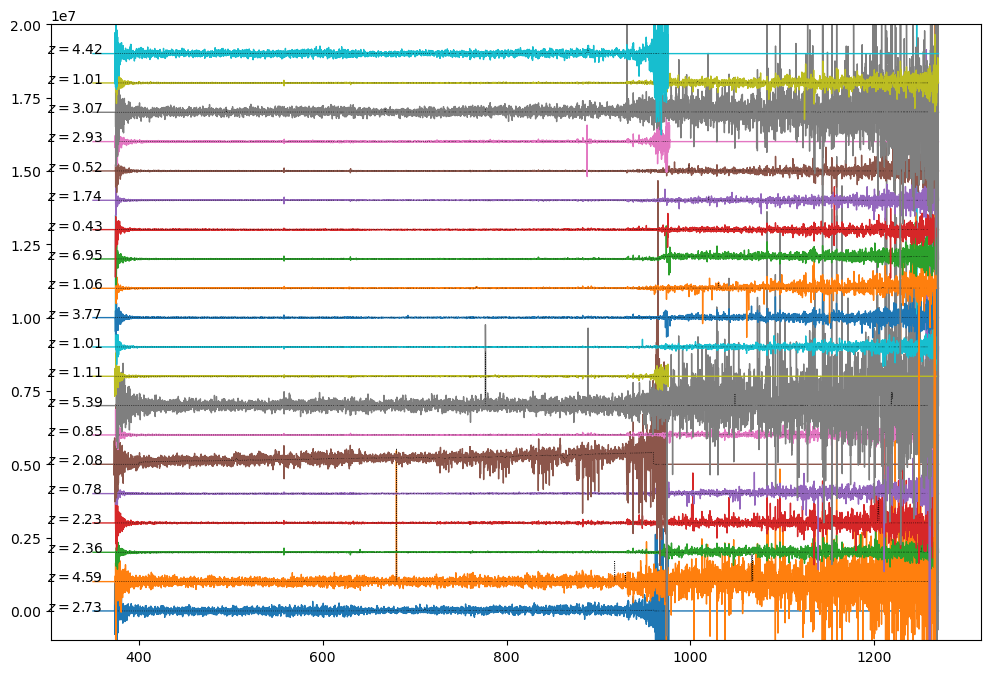

In [6]:
fig = plt.figure(figsize=(12,8))
sub = fig.add_subplot(111)

i = 0 
for f in glob.glob('/shared/lam1d/rerun/edr2-20231203_v2/pfsZcandidates-00009*fits')[:1000]: 
    fspec = glob.glob(os.path.join('/shared/2d/rerun/edr2-20231203/pfsObject/00009/00001/1,1/', 
                                   '-'.join(f.split('/')[-1].replace('pfsZcandidates', 'pfsObject').split('-')[:-2])+'*.fits'))[0]
    if not os.path.isfile(fspec): continue
    try: 
        lam = fits.open(f)
        zwarn_galaxy = lam[0].header['HIERARCH GALAXY_ZWARNING']
        p_galaxy = lam[1].header['P_GALAXY']
        zred_galaxy = lam[2].data['Z'][0] # bestfit redshift (I think)
        zerr_galaxy = lam[2].data['Z_ERR'][0] # bestfit redshift (I think)
    except: 
        continue
    if p_galaxy < 0.95 or zwarn_galaxy != 0: continue
        
    pfsObject = datamodel.PfsObject.readFits(fspec)
    
    bad = pfsObject.mask & pfsObject.flags.get('BAD', 'CR', 'SAT') != 0
    good = ~bad
    sub.plot(pfsObject.wavelength[good], pfsObject.flux[good] + 1e6*i, linewidth=1, c='C%i' % i)
    sub.plot(pfsObject.wavelength, lam[2].data['MODELFLUX'][0] + 1e6*i, linewidth=0.5, label='model', c='k', ls=':')
    sub.text(300, pfsObject.flux[0] + 1e6*i, '$z=%.2f$' % zred_galaxy, fontsize=10)

    i += 1
    if i == 20: break
sub.set_ylim(-1e6, 2e7)
plt.show()

In [7]:
targs['HAS_LAM'] = np.zeros(len(targs)).astype(bool)
targs['ZWARN_GALAXY'] = np.zeros(len(targs)).astype(int)
targs['P_GALAXY'] = np.zeros(len(targs))
targs['Z_GALAXY'] = np.zeros(len(targs))
targs['ZERR_GALAXY'] = np.zeros(len(targs))
targs['HAS_NIR'] = np.zeros(len(targs)).astype(bool)

for f in glob.glob('/shared/lam1d/rerun/edr2-20231203_v2/pfsZcandidates-00009*fits'): 
    fspec = glob.glob(os.path.join('/shared/2d/rerun/edr2-20231203/pfsObject/00009/00001/1,1/', 
                                   '-'.join(f.split('/')[-1].replace('pfsZcandidates', 'pfsObject').split('-')[:-2])+'*.fits'))[0]
    if not os.path.isfile(fspec): continue
    try: 
        lam = fits.open(f)
        zwarn_galaxy = lam[0].header['HIERARCH GALAXY_ZWARNING']
        p_galaxy = lam[1].header['P_GALAXY']
        zred_galaxy = lam[2].data['Z'][0] # bestfit redshift (I think)
        zerr_galaxy = lam[2].data['Z_ERR'][0] # bestfit redshift (I think)
    except: 
        continue

    pfsObject = datamodel.PfsObject.readFits(fspec)

    if np.sum(targs['obj_id'] == pfsObject.target.objId) == 1: 
        im = np.where(targs['obj_id'] == pfsObject.target.objId)[0]
        targs['HAS_LAM'][im] = True
        targs['ZWARN_GALAXY'][im] = zwarn_galaxy
        targs['P_GALAXY'][im] = p_galaxy
        targs['Z_GALAXY'][im] = zred_galaxy
        targs['ZERR_GALAXY'][im] = zerr_galaxy
        targs['HAS_NIR'][im] = ~(np.sum(pfsObject.flux[good][-100:]) == 0)

In [8]:
targs

obj_id,ra,dec,g_cmodel_mag,g_cmodel_magerr,r_cmodel_mag,r_cmodel_magerr,i_cmodel_mag,i_cmodel_magerr,z_cmodel_mag,z_cmodel_magerr,y_cmodel_mag,y_cmodel_magerr,g_cmodel_flux,g_cmodel_fluxerr,r_cmodel_flux,r_cmodel_fluxerr,i_cmodel_flux,i_cmodel_fluxerr,z_cmodel_flux,z_cmodel_fluxerr,y_cmodel_flux,y_cmodel_fluxerr,HAS_LAM,ZWARN_GALAXY,P_GALAXY,Z_GALAXY,ZERR_GALAXY,HAS_NIR
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,int64,float64,float64,float64,bool
43365704967145244,219.58806439496792,1.583100010834337,24.032,0.040393874,24.109118,0.04799594,23.885166,0.032003265,23.52327,0.053351797,23.356781,0.10316485,885.5236,32.94514,824.8079,36.461372,1013.7563,29.881578,1414.7893,69.52108,1649.2529,156.70927,False,0,0.0,0.0,0.0,False
42297142873710495,218.5550514401301,1.2859814714896636,24.006561,0.020474253,23.927114,0.036991566,23.588879,0.022403108,23.690155,0.06582771,23.40154,0.115666285,906.5153,17.094599,975.3361,33.230183,1331.8287,27.480988,1213.2157,73.55674,1582.6465,168.60342,False,0,0.0,0.0,0.0,False
42292031862631098,217.87579070240025,0.2437820471078315,24.371178,0.03318277,24.318323,0.046417374,24.04773,0.04081232,23.728903,0.073064424,23.404526,0.12189379,647.93097,19.802364,680.2534,29.082182,872.78613,32.80763,1170.6815,78.78081,1578.3014,177.19327,False,0,0.0,0.0,0.0,False
43365288355303809,220.157124947886,1.488463741531131,24.331495,0.032082427,24.106194,0.04142757,23.822643,0.028186295,23.321875,0.045915663,23.187548,0.06989933,672.0505,19.858425,827.0329,31.556435,1073.8467,27.877638,1703.1388,72.02555,1927.4395,124.0879,False,0,0.0,0.0,0.0,False
43360765754756197,218.8278508497116,1.9561370317484548,24.295273,0.06377363,24.154543,0.062186655,23.560455,0.037615664,23.294035,0.09508873,--,--,694.8497,40.81386,791.0114,45.305992,1367.1554,47.36552,1747.3748,153.035,--,--,False,0,0.0,0.0,0.0,False
42296180801033038,219.72838598988483,1.2646391113948718,24.601398,0.05992284,24.432835,0.091124035,24.54345,0.06788697,24.112965,0.10094889,24.410156,0.27763152,524.1318,28.927345,612.1611,51.377663,552.86633,34.568638,821.8915,76.417305,625.08234,159.83861,False,0,0.0,0.0,0.0,False
43365838111139079,219.48973618218875,1.5413428018218096,24.823114,0.07889078,24.565117,0.07386382,24.243855,0.05620135,23.669405,0.07475076,23.830208,0.1696284,427.32077,31.049595,541.94305,36.86898,728.5481,37.712097,1236.6252,85.139175,1066.3917,166.60614,True,0,1.0,0.3893699049949646,2.8828679205616936e-05,False
43369965574690154,221.36006226517773,1.7011040098672645,24.441128,0.063539326,24.35889,0.08254498,23.935902,0.04126972,23.644901,0.06756729,23.657585,0.14939551,607.5031,35.552227,655.3059,49.820774,967.47394,36.774475,1264.8511,78.71393,1250.1609,172.02008,False,0,0.0,0.0,0.0,False
43360770049725930,218.85915045026215,2.271747247817197,23.713758,0.051199045,23.5648,0.04401643,23.048897,0.015515405,22.421825,0.021324366,22.247087,0.11795032,1187.1249,55.98014,1361.6936,55.20392,2189.9866,31.295382,3901.8386,76.633934,4583.1606,497.89746,False,0,0.0,0.0,0.0,False


In [9]:
print(np.sum(targs['HAS_LAM']), len(targs))

3402 200000


In [10]:
targs_lam = targs[targs['HAS_LAM']]
targs_lam.write('PFS_EDR2.cosmology.lam1d.hdf5')

/opt/pfs/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-3.0.0/lib/python3.8/site-packages/astropy/io/misc/hdf5.py:283: UserWarning: table path was not set via the path= argument; using default path __astropy_table__
  warnings.warn(


# preliminary target selection 
- magnitude cut: 22.5 < i_mag <24.0
- quality cut: g_mag_err < 0.05 g_mag - 1.1
- redshift color cut:

(g_mag-r_mag)<0.15) 
or (i_mag-z_mag)>2.0(g_mag-r_mag)-0.15

- star-galaxy separation
i_cmodel - i_psf < -0.15（-0.05）

In [6]:
targs_lam = aT.read('PFS_EDR2.cosmology.lam1d.hdf5')

In [54]:
is_zwarn = (targs_lam['ZWARN_GALAXY'] == 0)
print('%i of %i has ZWARN=0' % (np.sum(is_zwarn), len(targs_lam)))
has_nir = (targs_lam['HAS_NIR'])
print('%i of %i has NIR spectra' % (np.sum(has_nir), len(targs_lam)))
is_gal = (targs_lam['P_GALAXY'] > 0.9)
print('%i of %i is classified as galaxy' % (np.sum(is_gal), len(targs_lam)))

390 of 3402 has ZWARN=0
2544 of 3402 has NIR spectra
2837 of 3402 is classified as galaxy


In [55]:
cut0 = (is_zwarn & has_nir & is_gal)
print('%i passes ZWARN, has NIR, and are Galaxies' % np.sum(cut0))

270 passes ZWARN, has NIR, and are Galaxies


In [7]:
mag_cut = (targs_lam['i_cmodel_mag'] > 22.5) & (targs_lam['i_cmodel_mag'] < 24.0)
print('%i within magnitude cut' % np.sum(mag_cut))

quality_cut = (targs_lam['g_cmodel_magerr'] < 0.05 * targs_lam['g_cmodel_mag'] - 1.1)
print('%i within quality cut' % np.sum(quality_cut))
print('%i within magnitude + quality cuts' % np.sum(mag_cut & quality_cut))

2104 within magnitude cut
3332 within quality cut
2070 within magnitude + quality cuts


(-1.0, 1.5)

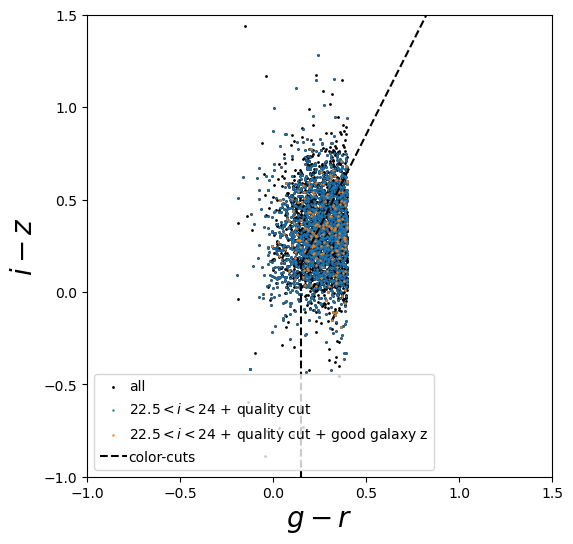

In [61]:
# (g-r) vs (i-z) color color plot 
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.scatter((targs_lam['g_cmodel_mag'] - targs_lam['r_cmodel_mag']), 
            (targs_lam['i_cmodel_mag'] - targs_lam['z_cmodel_mag']), 
            c='k', s=1, label='all')
sub.scatter((targs_lam['g_cmodel_mag'] - targs_lam['r_cmodel_mag'])[mag_cut & quality_cut], 
            (targs_lam['i_cmodel_mag'] - targs_lam['z_cmodel_mag'])[mag_cut & quality_cut], 
            c='C0', s=0.5, label='$22.5 < i < 24$ + quality cut')
sub.scatter((targs_lam['g_cmodel_mag'] - targs_lam['r_cmodel_mag'])[cut0 & mag_cut & quality_cut], 
            (targs_lam['i_cmodel_mag'] - targs_lam['z_cmodel_mag'])[cut0 & mag_cut & quality_cut], 
            c='C1', s=0.5, label='$22.5 < i < 24$ + quality cut + good galaxy z')
sub.plot([0.15, 0.15], [-2., 0.15], c='k', ls='--')
sub.plot([0.15, 2], [0.15, 3.85], c='k', ls='--', label='color-cuts') 
sub.legend(loc='lower left', handletextpad=0.1, fontsize=10)
sub.set_xlabel(r'$g - r$', fontsize=20)
sub.set_ylabel(r'$i - z$', fontsize=20)
sub.set_xlim(-1.0, 1.5)
sub.set_ylim(-1.0, 1.5)

Text(0, 0.5, '$N_{\\rm gal}$ usable spectra')

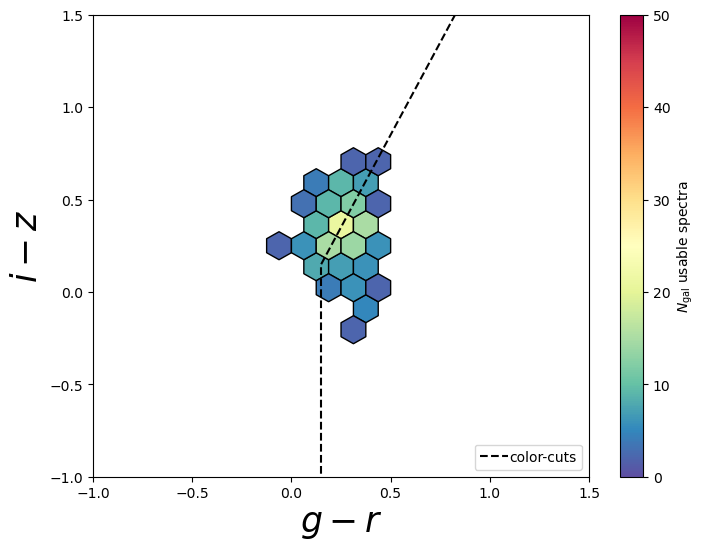

In [74]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)

hb = sub.hexbin((targs_lam['g_cmodel_mag'] - targs_lam['r_cmodel_mag'])[cut0 & mag_cut & quality_cut], 
                (targs_lam['i_cmodel_mag'] - targs_lam['z_cmodel_mag'])[cut0 & mag_cut & quality_cut], 
                reduce_C_function=len, 
                extent=(-1., 1.5, -1., 1.5), vmin=0., vmax=50,
                gridsize=20, mincnt=2, cmap='Spectral_r', edgecolors='k', linewidth=1.)
sub.plot([0.15, 0.15], [-2., 0.15], c='k', ls='--')
sub.plot([0.15, 2], [0.15, 3.85], c='k', ls='--', label='color-cuts') 
sub.legend(loc='lower right', handletextpad=0.1, fontsize=10)
sub.set_xlabel(r'$g - r$', fontsize=25)
sub.set_ylabel(r'$i - z$', fontsize=25)
sub.set_xlim(-1.0, 1.5)
sub.set_ylim(-1.0, 1.5)

cbar = fig.colorbar(hb)
cbar.ax.set_ylabel(r'$N_{\rm gal}$ usable spectra', fontsize=10)

Text(0, 0.5, '$z$ fraction')

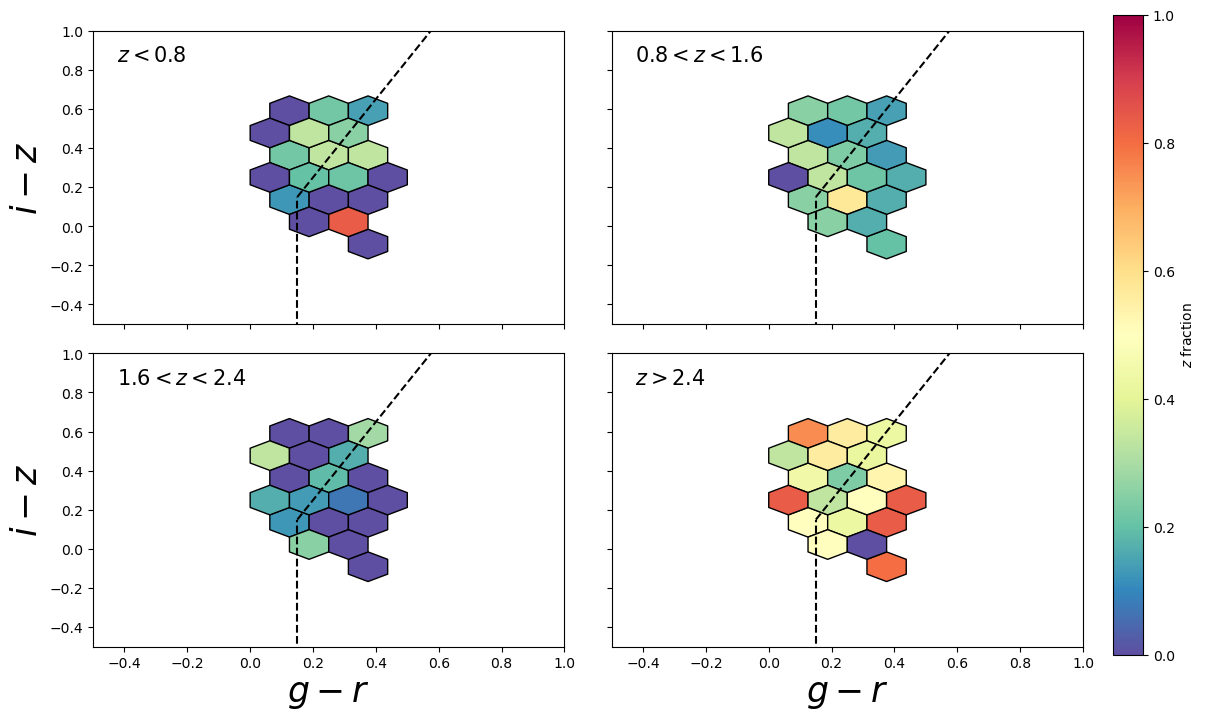

In [75]:
zlim0 = (targs_lam['Z_GALAXY'] < 0.8)
zlim1 = (targs_lam['Z_GALAXY'] > 0.8) & (targs_lam['Z_GALAXY'] < 1.6)
zlim2 = (targs_lam['Z_GALAXY'] > 1.6) & (targs_lam['Z_GALAXY'] < 2.4)
zlim3 = (targs_lam['Z_GALAXY'] > 2.4)

fig = plt.figure(figsize=(12,8))
for i, zlim in enumerate([zlim0, zlim1, zlim2, zlim3]): 
    sub = fig.add_subplot(2,2,i+1)

    hb = sub.hexbin((targs_lam['g_cmodel_mag'] - targs_lam['r_cmodel_mag'])[cut0 & mag_cut & quality_cut], 
                    (targs_lam['i_cmodel_mag'] - targs_lam['z_cmodel_mag'])[cut0 & mag_cut & quality_cut], 
                    C=zlim[cut0 & mag_cut & quality_cut], reduce_C_function=np.mean, 
                    extent=(-1., 1.5, -1., 1.5), vmin=0., vmax=1.,
                    gridsize=20, mincnt=2, cmap='Spectral_r', edgecolors='k', linewidth=1.)
    sub.text(0.05, 0.95, ['$z < 0.8$', '$0.8 < z < 1.6$', '$1.6 < z < 2.4$', '$z > 2.4$'][i], 
             transform=sub.transAxes, ha='left', va='top', fontsize=15)
    sub.plot([0.15, 0.15], [-2., 0.15], c='k', ls='--')
    sub.plot([0.15, 2], [0.15, 3.85], c='k', ls='--', label='color-cuts') 
    if i > 1: sub.set_xlabel(r'$g - r$', fontsize=25)
    else: sub.set_xticklabels([])
    if i == 0 or i == 2: 
        sub.set_ylabel(r'$i - z$', fontsize=25)
    else: sub.set_yticklabels([])
    sub.set_xlim(-0.5, 1.)
    sub.set_ylim(-0.5, 1.)
    
fig.subplots_adjust(hspace=0.1, wspace=0.1, right=0.95)
cax = plt.axes((0.975, 0.1, 0.025, 0.8))
cbar = plt.colorbar(hb, cax=cax)
cbar.ax.set_ylabel(r'$z$ fraction', fontsize=10)

Text(0, 0.5, 'fraction within $0.8 < z <2.4$')

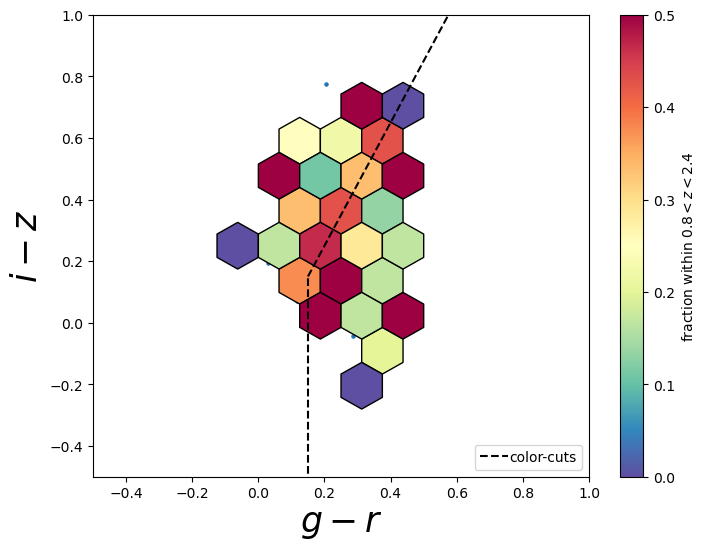

In [73]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)

sub.scatter((targs_lam['g_cmodel_mag'] - targs_lam['r_cmodel_mag'])[cut0 & mag_cut & quality_cut], 
            (targs_lam['i_cmodel_mag'] - targs_lam['z_cmodel_mag'])[cut0 & mag_cut & quality_cut], 
            c='C0', s=5)
hb = sub.hexbin((targs_lam['g_cmodel_mag'] - targs_lam['r_cmodel_mag'])[cut0 & mag_cut & quality_cut], 
                (targs_lam['i_cmodel_mag'] - targs_lam['z_cmodel_mag'])[cut0 & mag_cut & quality_cut], 
                C=(zlim1 | zlim2)[cut0 & mag_cut & quality_cut], reduce_C_function=np.mean, 
                extent=(-1., 1.5, -1., 1.5), vmin=0., vmax=0.5,
                gridsize=20, mincnt=1, cmap='Spectral_r', edgecolors='k', linewidth=1.)
sub.plot([0.15, 0.15], [-2., 0.15], c='k', ls='--')
sub.plot([0.15, 2], [0.15, 3.85], c='k', ls='--', label='color-cuts') 
sub.legend(loc='lower right', handletextpad=0.1, fontsize=10)
sub.set_xlabel(r'$g - r$', fontsize=25)
sub.set_ylabel(r'$i - z$', fontsize=25)
sub.set_xlim(-0.5, 1.)
sub.set_ylim(-0.5, 1.)

cbar = fig.colorbar(hb)
cbar.ax.set_ylabel(r'fraction within $0.8 < z <2.4$', fontsize=10)

In [32]:
from hscdata import sql

In [37]:
script = f'''
SELECT
     meas.object_id
    , meas.parent_id
    , meas.tract
    , meas.patch
    , meas.i_ra
    , meas.i_dec
    , meas.i_variance_value
    , meas.i_footprintarea_value
    ,meas.skymap_id
    ,meas2.i_psfflux_mag as meas_i_psfflux_mag

    --patch
    ,patch_qa.patch
    ,patch_qa.skymap_id
    ,patch_qa.ra
    ,patch_qa.dec
    
    --depth
    ,patch_qa.gmag_psf_depth  as g_depth
    ,patch_qa.rmag_psf_depth  as r_depth
    ,patch_qa.imag_psf_depth  as i_depth
    ,patch_qa.zmag_psf_depth  as z_depth
    ,patch_qa.ymag_psf_depth  as y_depth
    
    --psf size
    ,patch_qa.gseeing
    ,patch_qa.rseeing
    ,patch_qa.iseeing
    ,patch_qa.zseeing
    ,patch_qa.yseeing
        
    -- forced measurement (extinction needed, subtract this to get magnitude)
    , forced.a_g
    , forced.a_r
    ,forced.a_i
    , forced.a_z
    , forced.a_y
    
    -- forced CModel magnitudes and fluxes (needed)
    , forced.g_cmodel_mag       as forced_g_cmodel_mag
    , forced.g_cmodel_magerr    as forced_g_cmodel_magerr
    
    , forced.r_cmodel_mag       as forced_r_cmodel_mag
    , forced.r_cmodel_magerr    as forced_r_cmodel_magerr
    
    , forced.i_cmodel_mag       as forced_i_cmodel_mag
    , forced.i_cmodel_magerr    as forced_i_cmodel_magerr
    
    , forced.z_cmodel_mag       as forced_z_cmodel_mag
    , forced.z_cmodel_magerr    as forced_z_cmodel_magerr
        
    , forced.y_cmodel_mag       as forced_y_cmodel_mag
    , forced.y_cmodel_magerr    as forced_y_cmodel_magerr
    
    --meas Cmodel mag
    , meas.g_cmodel_mag       as meas_g_cmodel_mag
    , meas.g_cmodel_magerr    as meas_g_cmodel_magerr
    
    , meas.r_cmodel_mag       as meas_r_cmodel_mag
    , meas.r_cmodel_magerr    as meas_r_cmodel_magerr
    
    , meas.i_cmodel_mag       as meas_i_cmodel_mag
    , meas.i_cmodel_magerr    as meas_i_cmodel_magerr
    
    , meas.z_cmodel_mag       as meas_z_cmodel_mag
    , meas.z_cmodel_magerr    as meas_z_cmodel_magerr
        
    , meas.y_cmodel_mag       as meas_y_cmodel_mag
    , meas.y_cmodel_magerr    as meas_y_cmodel_magerr
    
    
    --forced psf
    --, forced2.g_psfflux_mag as forced_g_psf_mag
    --, forced2.g_psfflux_magerr as forced_g_psf_magerr
    
    --, forced2.r_psfflux_mag as forced_r_psf_mag
    --, forced2.r_psfflux_magerr as forced_r_psf_magerr
    
    --, forced2.i_psfflux_mag as forced_i_psf_mag
    --, forced2.i_psfflux_magerr as forced_i_psf_magerr
    
    --, forced2.z_psfflux_mag as forced_z_psf_mag
    --, forced2.z_psfflux_magerr as forced_z_psf_magerr
    
    --, forced2.y_psfflux_mag as forced_y_psf_mag
    --, forced2.y_psfflux_magerr as forced_y_psf_magerr
    
    -- columns which can be used for selection (needed)
    --, forced3.g_apertureflux_10_mag as forced_g_apertureflux_10_mag
    --, forced3.g_apertureflux_10_magerr as forced_g_apertureflux_10_magerr
    
    --, forced3.r_apertureflux_10_mag as forced_r_apertureflux_10_mag
    --, forced3.r_apertureflux_10_magerr as forced_r_apertureflux_10_magerr
    
    --, forced3.i_apertureflux_10_mag as forced_i_apertureflux_10_mag
    --, forced3.i_apertureflux_10_magerr as forced_i_apertureflux_10_magerr
    
    --, forced3.z_apertureflux_10_mag as forced_z_apertureflux_10_mag
    --, forced3.z_apertureflux_10_magerr as forced_z_apertureflux_10_magerr
    
    --, forced3.y_apertureflux_10_mag as forced_y_apertureflux_10_mag
    --, forced3.y_apertureflux_10_magerr as forced_y_apertureflux_10_magerr

FROM
    s21a_wide.meas as meas
    --LEFT JOIN s18a_dud_u2k.forced as s18a_forced using (object_id)
    LEFT JOIN s21a_wide.meas2 as meas2 using (object_id)
    LEFT JOIN s21a_wide.meas3 as meas3 using (object_id)
    LEFT JOIN s21a_wide.patch_qa as patch_qa on meas.skymap_id=patch_qa.skymap_id
    LEFT JOIN s21a_wide.forced as forced using (object_id)
    LEFT JOIN s21a_wide.forced2 as forced2 using (object_id)
    
    
    -- select region by region
    -- region1: ra = [126.536996, 227.374634], dec = [-3.266990, 6.347560]
    -- region2: ra = [197.866832, 251.622786], dec = [41.072401, 45.624517]
    -- region3: ra = [328.803739, 41.067016], dec = [-7.991096, 8.372002]
WHERE
    NOT meas.i_deblend_skipped                  AND
    NOT meas2.i_sdsscentroid_flag               AND
    NOT meas.i_pixelflags_edge                  AND
    NOT meas.i_pixelflags_interpolatedcenter    AND
    NOT meas.i_pixelflags_saturatedcenter       AND
    NOT meas.i_pixelflags_crcenter              AND
    NOT meas.i_pixelflags_bad                   AND
    NOT meas.i_pixelflags_suspectcenter         AND
    meas.i_detect_isprimary
    --- NOT meas.i_pixelflags_clipped           AND --no need
    --- NOT meas2.i_hsmshaperegauss_flag        AND --no need
    --- meas2.i_hsmshaperegauss_sigma != 'NaN'  AND --no need
    
    --- select galaxies: extendedness != 0
    --- stars: extendedness == 0
    --- meas.i_extendedness_value != 0
    --meas.i_cmodel_mag - meas2.i_psfflux_mag <-0.15
    --meas3.i_kronflux_psf_radius - meas3.i_kronflux_radius < -0.015
ORDER BY meas.object_id
'''

In [38]:
hscData = sql.pandas_read_sql(script)

DatabaseError: Execution failed on sql '
SELECT
     meas.object_id
    , meas.parent_id
    , meas.tract
    , meas.patch
    , meas.i_ra
    , meas.i_dec
    , meas.i_variance_value
    , meas.i_footprintarea_value
    ,meas.skymap_id
    ,meas2.i_psfflux_mag as meas_i_psfflux_mag

    --patch
    ,patch_qa.patch
    ,patch_qa.skymap_id
    ,patch_qa.ra
    ,patch_qa.dec
    
    --depth
    ,patch_qa.gmag_psf_depth  as g_depth
    ,patch_qa.rmag_psf_depth  as r_depth
    ,patch_qa.imag_psf_depth  as i_depth
    ,patch_qa.zmag_psf_depth  as z_depth
    ,patch_qa.ymag_psf_depth  as y_depth
    
    --psf size
    ,patch_qa.gseeing
    ,patch_qa.rseeing
    ,patch_qa.iseeing
    ,patch_qa.zseeing
    ,patch_qa.yseeing
        
    -- forced measurement (extinction needed, subtract this to get magnitude)
    , forced.a_g
    , forced.a_r
    ,forced.a_i
    , forced.a_z
    , forced.a_y
    
    -- forced CModel magnitudes and fluxes (needed)
    , forced.g_cmodel_mag       as forced_g_cmodel_mag
    , forced.g_cmodel_magerr    as forced_g_cmodel_magerr
    
    , forced.r_cmodel_mag       as forced_r_cmodel_mag
    , forced.r_cmodel_magerr    as forced_r_cmodel_magerr
    
    , forced.i_cmodel_mag       as forced_i_cmodel_mag
    , forced.i_cmodel_magerr    as forced_i_cmodel_magerr
    
    , forced.z_cmodel_mag       as forced_z_cmodel_mag
    , forced.z_cmodel_magerr    as forced_z_cmodel_magerr
        
    , forced.y_cmodel_mag       as forced_y_cmodel_mag
    , forced.y_cmodel_magerr    as forced_y_cmodel_magerr
    
    --meas Cmodel mag
    , meas.g_cmodel_mag       as meas_g_cmodel_mag
    , meas.g_cmodel_magerr    as meas_g_cmodel_magerr
    
    , meas.r_cmodel_mag       as meas_r_cmodel_mag
    , meas.r_cmodel_magerr    as meas_r_cmodel_magerr
    
    , meas.i_cmodel_mag       as meas_i_cmodel_mag
    , meas.i_cmodel_magerr    as meas_i_cmodel_magerr
    
    , meas.z_cmodel_mag       as meas_z_cmodel_mag
    , meas.z_cmodel_magerr    as meas_z_cmodel_magerr
        
    , meas.y_cmodel_mag       as meas_y_cmodel_mag
    , meas.y_cmodel_magerr    as meas_y_cmodel_magerr
    
    
    --forced psf
    --, forced2.g_psfflux_mag as forced_g_psf_mag
    --, forced2.g_psfflux_magerr as forced_g_psf_magerr
    
    --, forced2.r_psfflux_mag as forced_r_psf_mag
    --, forced2.r_psfflux_magerr as forced_r_psf_magerr
    
    --, forced2.i_psfflux_mag as forced_i_psf_mag
    --, forced2.i_psfflux_magerr as forced_i_psf_magerr
    
    --, forced2.z_psfflux_mag as forced_z_psf_mag
    --, forced2.z_psfflux_magerr as forced_z_psf_magerr
    
    --, forced2.y_psfflux_mag as forced_y_psf_mag
    --, forced2.y_psfflux_magerr as forced_y_psf_magerr
    
    -- columns which can be used for selection (needed)
    --, forced3.g_apertureflux_10_mag as forced_g_apertureflux_10_mag
    --, forced3.g_apertureflux_10_magerr as forced_g_apertureflux_10_magerr
    
    --, forced3.r_apertureflux_10_mag as forced_r_apertureflux_10_mag
    --, forced3.r_apertureflux_10_magerr as forced_r_apertureflux_10_magerr
    
    --, forced3.i_apertureflux_10_mag as forced_i_apertureflux_10_mag
    --, forced3.i_apertureflux_10_magerr as forced_i_apertureflux_10_magerr
    
    --, forced3.z_apertureflux_10_mag as forced_z_apertureflux_10_mag
    --, forced3.z_apertureflux_10_magerr as forced_z_apertureflux_10_magerr
    
    --, forced3.y_apertureflux_10_mag as forced_y_apertureflux_10_mag
    --, forced3.y_apertureflux_10_magerr as forced_y_apertureflux_10_magerr

FROM
    s21a_wide.meas as meas
    --LEFT JOIN s18a_dud_u2k.forced as s18a_forced using (object_id)
    LEFT JOIN s21a_wide.meas2 as meas2 using (object_id)
    LEFT JOIN s21a_wide.meas3 as meas3 using (object_id)
    LEFT JOIN s21a_wide.patch_qa as patch_qa on meas.skymap_id=patch_qa.skymap_id
    LEFT JOIN s21a_wide.forced as forced using (object_id)
    LEFT JOIN s21a_wide.forced2 as forced2 using (object_id)
    
    
    -- select region by region
    -- region1: ra = [126.536996, 227.374634], dec = [-3.266990, 6.347560]
    -- region2: ra = [197.866832, 251.622786], dec = [41.072401, 45.624517]
    -- region3: ra = [328.803739, 41.067016], dec = [-7.991096, 8.372002]
WHERE
    NOT meas.i_deblend_skipped                  AND
    NOT meas2.i_sdsscentroid_flag               AND
    NOT meas.i_pixelflags_edge                  AND
    NOT meas.i_pixelflags_interpolatedcenter    AND
    NOT meas.i_pixelflags_saturatedcenter       AND
    NOT meas.i_pixelflags_crcenter              AND
    NOT meas.i_pixelflags_bad                   AND
    NOT meas.i_pixelflags_suspectcenter         AND
    meas.i_detect_isprimary
    --- NOT meas.i_pixelflags_clipped           AND --no need
    --- NOT meas2.i_hsmshaperegauss_flag        AND --no need
    --- meas2.i_hsmshaperegauss_sigma != 'NaN'  AND --no need
    
    --- select galaxies: extendedness != 0
    --- stars: extendedness == 0
    --- meas.i_extendedness_value != 0
    --meas.i_cmodel_mag - meas2.i_psfflux_mag <-0.15
    --meas3.i_kronflux_psf_radius - meas3.i_kronflux_radius < -0.015
ORDER BY meas.object_id
': relation "s21a_wide.meas" does not exist
LINE 107:     s21a_wide.meas as meas
              ^
